In [1]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import pickle

In [19]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !pip install catboost
    from catboost import CatBoostClassifier
    import os
    import urllib.request
    urllib.request.urlretrieve('https://raw.githubusercontent.com/doanthuan/viettelpay/master/util.py', 'util.py')
    from util import *
    DATA_DIR = "/content/drive/MyDrive/projects/viettelpay/code/data"
else:
    print('Not running on CoLab')
    from catboost import CatBoostClassifier
    from util import *
    DATA_DIR = "data"

Not running on CoLab


In [2]:
pd.set_option('max_columns', None)
#pd.set_option("max_rows", None)

In [3]:
use_cols = [
    "request_date",
    "is_fraud",
    "province_code",
    "district_code",
    "viettel_bank_code",
    "channel_type_id",
    "channel_code",
    "staff_code",
    "trans_amount",
    "trans_fee",
    "trans_type",
    "process_code",
    "channel_fee",
    "shop_code",
    "customer_fee",
    "cust_name",
    "ben_cust_name",
    "msisdn",
    "ben_msisdn",
    "msisdn_channel",
    "staff_name"
]
train = pd.read_parquet(DATA_DIR+"/data-2m.snappy.parquet", columns=use_cols)
train.head()

,request_date,is_fraud,province_code,district_code,viettel_bank_code,channel_type_id,channel_code,staff_code,trans_amount,trans_fee,trans_type,process_code,channel_fee,shop_code,customer_fee,cust_name,ben_cust_name,msisdn,ben_msisdn,msisdn_channel,staff_name
0,2020-07-20 02:54:32,0,T008,T00801,KPP,163,4400590001,4400590001,1000000.0,8182.0,4,517000,7200.0,4400590001,18000.0,Tran Thi Bich Van,Thach Quoc Bao,00018f71c1cc10d15963,0001ddaf20bf9527ab20,0001db3e096d46c51b2f,None
1,2020-07-20 10:00:47,0,H004,H004013,VIETTEL,164,ANHKP_VTPOST_HNI,ANHKP_VTPOST_HNI,153598.0,1000.0,3,666003,550.0,1800240005,0.0,Nguyen Van Muon,Nguyen Van Muon,0001f10df0e9dc76348c,None,0001fedb1166ef86223f,Kiều Phương Anh
2,2020-07-20 04:26:55,0,T008,T00801,KPP,163,4400590001,4400590001,800000.0,8182.0,1,645200,7200.0,4400590001,18000.0,Nguyen Ngoc Si,Nguyen Thi Cam Trang,000141be9248e7b99368,00018b84ac3a67efed57,0001db3e096d46c51b2f,None
3,2020-07-20 16:47:45,0,N350,N350005,KPP,1,1000640100_00994_DB,1000640100_00994_DB,294546.0,1000.0,3,KPP301,770.0,1000640100_VTP,0.0,None,None,0001c5fadb5cd989c63f,None,0001c5fadb5cd989c63f,ha anh tuan
4,2020-07-20 12:00:24,0,D061,D061001,KPP,1,1200019124_02577_DB,1200019124_02577_DB,360358.0,1000.0,3,KPP301,770.0,1200019124_VTP,0.0,None,None,0001c60a841f0d66fc35,None,00019c24bf58e516f546,Diem CCDVVT LD CH Manh Hung _Bui Manh Hung


In [4]:
account = pd.read_parquet(DATA_DIR+"/account_sale_mapping.snappy.parquet")
sale = pd.read_parquet(DATA_DIR+"/account_sale.snappy.parquet")

In [5]:
trans_hist = pd.read_parquet(DATA_DIR+"/trans_hist_2m.snappy.parquet")
trans_hist = trans_hist.groupby(['msisdn'], as_index=False).agg({'trans_amount':['sum', 'mean']})
trans_hist.columns = ['_'.join(col) for col in trans_hist.columns]

In [6]:
features = [
    "province_code",
    "district_code",
    "viettel_bank_code",
    "channel_type_id",
    "channel_code",
    "staff_code",
    "trans_amount",
    "trans_fee",
    "trans_type",
    "process_code",
    "channel_fee",
    "shop_code",
    "customer_fee",
    "cust_name",
    "ben_cust_name",
    "msisdn",
    "ben_msisdn",
    "msisdn_channel",
    "staff_name",
    
    "msisdn_",
    "trans_amount_sum",
    "trans_amount_mean",
    "RW000076",
    "date_diff"
]

cat_features = [
    'viettel_bank_code',
    'msisdn_channel',
    'msisdn_',
    'msisdn',
    'district_code',
    'process_code',
    'staff_code',
    'ben_msisdn',
    'shop_code',
    'province_code',
    'channel_code',
    'cust_name',
    'trans_type',
    'staff_name',
    'ben_cust_name',
    'channel_type_id'
]

X, y = preprocess_data(train, account, sale, trans_hist, features, cat_features)

In [7]:
# y = train['is_fraud']
# X = train.drop(['is_fraud'], axis = 1)
# y_test = test['is_fraud']
# X_test = test.drop(['is_fraud'], axis = 1)
    
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=42)

In [8]:
cat_model = CatBoostClassifier(
    iterations=1000,
    max_ctr_complexity=1,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=25,
    depth=6,
    task_type="GPU",
    loss_function="Logloss",
    eval_metric="AUC"
)

cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val)
)

Learning rate set to 0.031154
0:	learn: 0.9020311	test: 0.9282218	best: 0.9282218 (0)	total: 481ms	remaining: 8m
25:	learn: 0.9954358	test: 0.9968628	best: 0.9968628 (25)	total: 12.9s	remaining: 8m 2s
50:	learn: 0.9969675	test: 0.9979018	best: 0.9979033 (49)	total: 25s	remaining: 7m 45s
75:	learn: 0.9971088	test: 0.9980640	best: 0.9980640 (75)	total: 37.3s	remaining: 7m 33s
100:	learn: 0.9972282	test: 0.9981664	best: 0.9981664 (100)	total: 49.6s	remaining: 7m 21s
125:	learn: 0.9974022	test: 0.9982652	best: 0.9982652 (125)	total: 1m 2s	remaining: 7m 11s
150:	learn: 0.9975098	test: 0.9983362	best: 0.9983362 (150)	total: 1m 14s	remaining: 6m 59s
175:	learn: 0.9975754	test: 0.9983771	best: 0.9983771 (175)	total: 1m 26s	remaining: 6m 46s
200:	learn: 0.9976222	test: 0.9984089	best: 0.9984089 (200)	total: 1m 38s	remaining: 6m 33s
225:	learn: 0.9976784	test: 0.9984445	best: 0.9984445 (225)	total: 1m 51s	remaining: 6m 20s
250:	learn: 0.9977258	test: 0.9984723	best: 0.9984723 (250)	total: 2m 3s	

In [9]:
#save_model(cat_model, 'cat-model.saved')
import gc
pickle.dump(cat_model, open('cat-model.saved', 'wb'))
del X, y, X_train, X_val, y_train, y_val
gc.collect()

22

In [10]:
loaded_cat_model = pickle.load(open('cat-model.saved', 'rb'))
test = pd.read_parquet(DATA_DIR+"/data-202008.snappy.parquet")

In [11]:
trans_hist = pd.read_parquet(DATA_DIR+"/trans_hist_202008.snappy.parquet")
trans_hist = trans_hist.groupby(['msisdn'], as_index=False).agg({'trans_amount':['sum', 'mean']})
trans_hist.columns = ['_'.join(col) for col in trans_hist.columns]

In [12]:
X_test, y_test = preprocess_data(test, account, sale, trans_hist, features, cat_features)

In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7367667 entries, 0 to 7367666
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   province_code      object 
 1   district_code      object 
 2   viettel_bank_code  object 
 3   channel_type_id    object 
 4   channel_code       object 
 5   staff_code         object 
 6   trans_amount       float64
 7   trans_fee          float64
 8   trans_type         object 
 9   process_code       object 
 10  channel_fee        float64
 11  shop_code          object 
 12  customer_fee       float64
 13  cust_name          object 
 14  ben_cust_name      object 
 15  msisdn             object 
 16  ben_msisdn         object 
 17  msisdn_channel     object 
 18  staff_name         object 
 19  msisdn_            object 
 20  trans_amount_sum   float64
 21  trans_amount_mean  float64
 22  RW000076           bool   
 23  date_diff          int64  
dtypes: bool(1), float64(6), int64(1), object(16)
memor

In [14]:
eval_model(loaded_cat_model, X_test, y_test)

classification_report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7339993
           1       0.73      0.66      0.69     27674

    accuracy                           1.00   7367667
   macro avg       0.86      0.83      0.85   7367667
weighted avg       1.00      1.00      1.00   7367667

confusion_matrix: 
[[7333143    6850]
 [   9400   18274]]
roc_auc_score: 0.8296988766032419
precision_score: 0.7273523324311415
recall_score: 0.66033099660331
f1_score: 0.6922231902723588


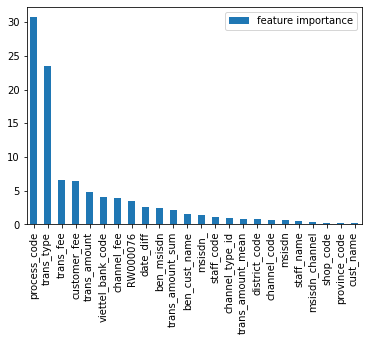

In [15]:
df_feature_importance = pd.DataFrame(loaded_cat_model.feature_importances_, index=features, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind='bar');

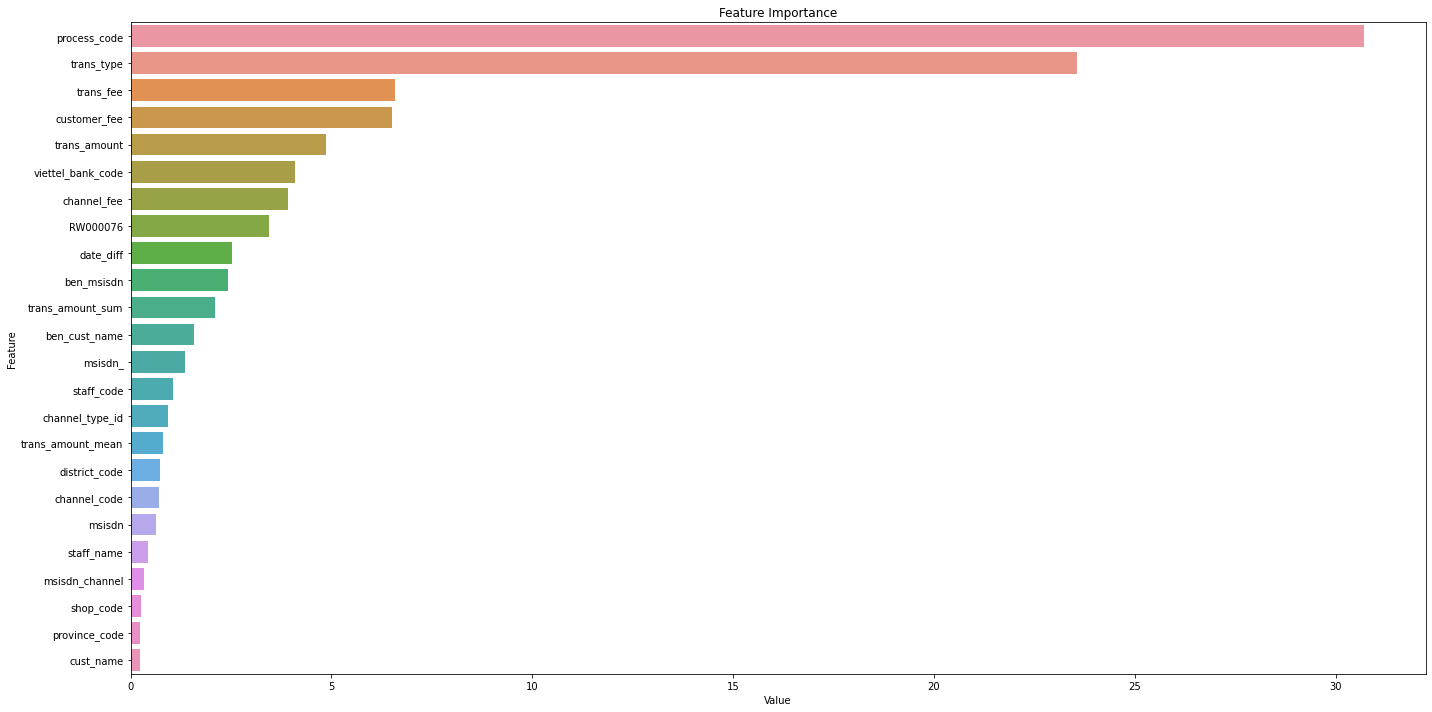

In [16]:
def plot_feature_importance(model, features):
    feature_importances = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value', 'Feature'])
    plt.figure(figsize=(20,10))
    sns.barplot(x="Value", y="Feature", data=feature_importances.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()
plot_feature_importance(loaded_cat_model, features)